# **Programming for Applied Deep Learning (GKSG008-01)**
> ### **20181202 김수미**
> ### LeNet_with_Conv2d(4) (Based on 11/23 Lecture)

(1) 6.6.4. Exercises 4 :  Display the activatinos of the first and second layer of LeNet for different inputs (e.g. sweaters and coats)
- When you display a single channle image with plt.imshow(), you need to specify colormap: plt.imshow (im, cmap="gray")
 
**Optional**

(2) Try to display those 5x5 weight matrices in the first Conv2d. <br> It has 6 convolution kernels of size 1x5x5, therefore you may display them using plt.imshow()
 
(3) The second Conv2d has 16 kernels. Each weight tensor of them is of 6x5x5.<br> If you display them all, you will be showing 16 rows and 6 columns of 5x5 images.

**◦ Import Libraries and Define Functions**

In [ ]:
pip install d2l

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

import numpy as np
import torchvision
import torch.utils.data as data
import torchvision.transforms as transforms
from d2l.torch import *
from torch.utils.data import DataLoader

In [4]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
  if isinstance(net, nn.Module):
    net.eval()
    if not device:
      device = next(iter(net.parameters())).device
  metric = d2l.Accumulator(2)

  with torch.no_grad():
    for X, y in data_iter:
      if isinstance(X, list):
        X = [x.to(device) for x in X]
      else:
        X = X.to(device)
      y = y.to(device)
      metric.add(d2l.accuracy(net(X), y), y.numel())
  return metric[0] / metric[1]

In [5]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_uniform_(m.weight)

  net.apply(init_weights)
  print('training on', device)
  net.to(device)
  optimizer = torch.optim.SGD(net.parameters(), lr=lr)
  loss = nn.CrossEntropyLoss()
  animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['train loss', 'train acc', 'test acc'])
  timer, num_batches = d2l.Timer(), len(train_iter)

  for epoch in range(num_epochs):
    metric = d2l.Accumulator(3)
    net.train()
    for i, (X, y) in enumerate(train_iter):
      timer.start()
      optimizer.zero_grad()
      X, y = X.to(device), y.to(device)
      y_hat = net(X)
      l = loss(y_hat, y)
      l.backward()
      optimizer.step()
      with torch.no_grad():
        metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
      timer.stop()
      train_l = metric[0] / metric[2]
      train_acc = metric[1] / metric[2]
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch + (i + 1) / num_batches, (train_l, train_acc, None))
    test_acc = evaluate_accuracy_gpu(net, test_iter)
    animator.add(epoch + 1, (None, None, test_acc))
    
  print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, 'f'test acc {test_acc:.3f}')
  print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec 'f'on {str(device)}')

**◦ Load Dataset (Fashion Mnist)**

In [ ]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [59]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5, padding=2),
                    nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5),
                    nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Flatten(),
                    nn.Linear(16 * 5 * 5, 120),
                    nn.Sigmoid(),
                    nn.Linear(120, 84),
                    nn.Sigmoid(),
                    nn.Linear(84, 10))

X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


loss 0.460, train acc 0.827, test acc 0.820
22130.7 examples/sec on cuda:0


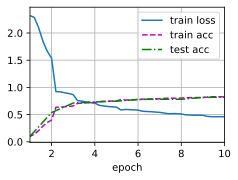

In [7]:
# Takes about 2.5 min
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**◦ Display the activations of the first and second layer of LeNet for different inputs (Fashion MNIST).**

In [ ]:
sample_data = []; flag = 0
for data in train_iter:
  x,y = data
  sample_data.append(x)
  flag += 1
  if flag == 2: break

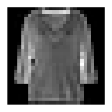

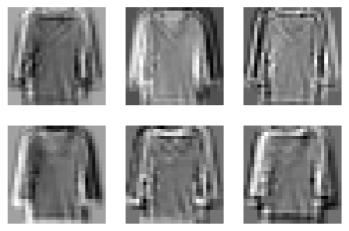

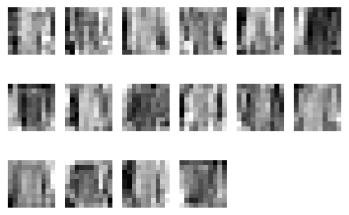

In [130]:
# original image (fashion mnist)
X = sample_data[0]
image = X[0,0]
plt.figure(figsize=(1.8,1.8)); plt.axis("off")
plt.imshow(image, cmap='gray')
indices = torch.tensor([0])
X = torch.index_select(X, 0, indices)

# 1st Conv2d layer
depth = 1; images=[];
for layer in net:
  if depth == 1:
    X = layer(X)
    for i in range(6):
      image = X[0,i]
      image = image.detach().numpy()
      images.append(image)
    break

fig = plt.figure()
rows,cols = 2,3
for i in range(6):
  ax1 = fig.add_subplot(rows, cols, i+1)
  ax1.imshow(images[i], cmap='gray')
  ax1.axis("off")
plt.show()

# 2nd Conv2d layer
X = sample_data[0]
indices = torch.tensor([0])
X = torch.index_select(X, 0, indices)

depth = 1; images=[];
for layer in net:
  X = layer(X)
  if depth == 4:
    for i in range(16):
      image = X[0,i]
      image = image.detach().numpy()
      images.append(image)
    break
  depth += 1

fig = plt.figure()
rows,cols = 3,6
for i in range(16):
  ax1 = fig.add_subplot(rows, cols, i+1)
  ax1.imshow(images[i], cmap='gray')
  ax1.axis("off")
plt.show()

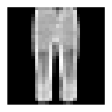

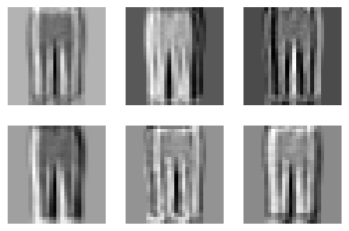

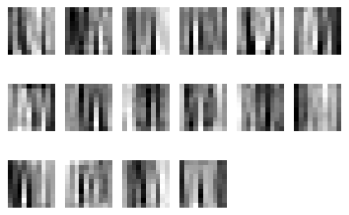

In [131]:
# original image (fashion mnist)
X = sample_data[1]
image = X[0,0]
plt.figure(figsize=(1.8,1.8)); plt.axis("off")
plt.imshow(image, cmap='gray')
indices = torch.tensor([0])
X = torch.index_select(X, 0, indices)

# 1st Conv2d layer
depth = 1; images=[];
for layer in net:
  if depth == 1:
    X = layer(X)
    for i in range(6):
      image = X[0,i]
      image = image.detach().numpy()
      images.append(image)
    break

fig = plt.figure()
rows,cols = 2,3
for i in range(6):
  ax1 = fig.add_subplot(rows, cols, i+1)
  ax1.imshow(images[i], cmap='gray')
  ax1.axis("off")
plt.show()

# 2nd Conv2d layer
X = sample_data[1]
indices = torch.tensor([0])
X = torch.index_select(X, 0, indices)

depth = 1; images=[];
for layer in net:
  X = layer(X)
  if depth == 4:
    for i in range(16):
      image = X[0,i]
      image = image.detach().numpy()
      images.append(image)
    break
  depth += 1

fig = plt.figure()
rows,cols = 3,6
for i in range(16):
  ax1 = fig.add_subplot(rows, cols, i+1)
  ax1.imshow(images[i], cmap='gray')
  ax1.axis("off")
plt.show()

**◦ Try to display 5x5 weight matrices in the first Conv2d.**
- It has 6 convolution kernels of size 1x5x5, therefore you may display them using plt.imshow()

In [11]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5, padding=2),
                    nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5),
                    nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Flatten(),
                    nn.Linear(16 * 5 * 5, 120),
                    nn.Sigmoid(),
                    nn.Linear(120, 84),
                    nn.Sigmoid(),
                    nn.Linear(84, 10))

X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


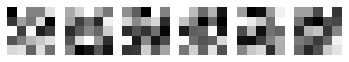

In [28]:
# User layer.weight function
images=[]
depth = 1
for layer in net:
  if depth == 1:
    X = layer.weight
    # print(X.shape)
    # print(X[0,0].shape)
    for i in range(6):
      image = X[i,0]
      image = image.detach().numpy()
      images.append(image)
    break

fig = plt.figure()
rows,cols = 1,6
for i in range(6):
  ax1 = fig.add_subplot(rows, cols, i+1)
  ax1.imshow(images[i], cmap='gray')
  ax1.axis("off")
plt.show()

**◦ The second Conv2d has 16 kernels. Each weight tensor of them is of 6x5x5. Try to display them.**
- If you display them all, you will be showing 16 rows and 6 columns of 5x5 images.

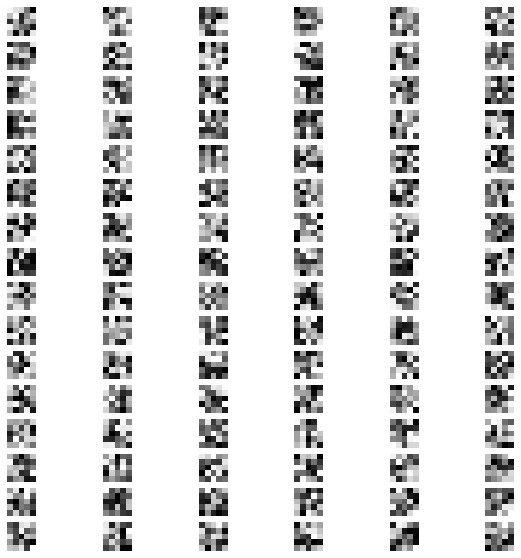

In [41]:
images=[]
depth = 1
for layer in net:
  if depth == 4:
    X = layer.weight
    # print(X.shape)
    # print(X[0,0].shape)
    for i in range(16):
      for j in range(6):
        image = X[i,j]
        image = image.detach().numpy()
        images.append(image)
    break
  depth += 1

fig = plt.figure(figsize=(10,10))
# rows,cols = 8,12
rows,cols = 16,6
for i in range(96):
  ax1 = fig.add_subplot(rows, cols, i+1)
  ax1.imshow(images[i], cmap='gray')
  ax1.axis("off")
plt.show()